In [3]:
import sys
sys.path.append('..')

# DBSCAN - Density-Based Spatial Clustering of Applications with Noise

## Learning objectives
- understand the DBSCAN algorithm
- implement the DBSCAN algorithm from scratch
- implement the DBSCAN algorithm in Sklearn

## Intro - The DBSCAN algorithm

DBSCAN is a non-parametric clustering technique. 
It does this by classifying points as 1 of 3 types: 
- core points - those with $\epsilon$ or more points within a radius of $d$ from it.  Core points are those with $\epsilon$ or more points within a radius of $d$ from it. 
- directly reachable points - those within a distance $d$ from a core point.
- noise points - those not within a distance $d$ from a core point.

In the image directly below, each example in our dataset is surrounded by a circle of radius $d$.
Red points are core points.
Yellow points are directly reachable points.
Blue points are noise points.

![](images/dbscan.png)

It can cluster arbitrarily shaped regions of datapoints, unlike K-means clustering. 

![](images/dbscan-clusters.png)

## Implementation from scratch

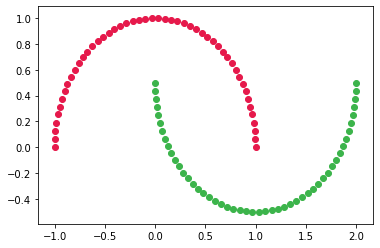

In [4]:
import numpy as np
np.set_printoptions(suppress=True)
from utils import get_classification_data, show_data, visualise_predictions, colors
import matplotlib.pyplot as plt
import sklearn.datasets
from time import sleep

X, Y = sklearn.datasets.make_moons()
# X, Y = get_classification_data()
show_data(X, Y)

distances: (100, 100)
cluster idx: 0
50
[0 1 0 1 1 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 1 1 0
 0 1 0 1 1 1 1 1 1 1 0 0 1 1 0 0 0 0 1 0 1 0 1 1 1 0 0 1 0 1 1 0 1 1 0 0 1
 0 0 0 0 1 0 1 1 0 1 1 1 0 0 1 0 0 0 0 1 1 1 0 1 1 1]
distances: (100, 100)
cluster idx: 0
50


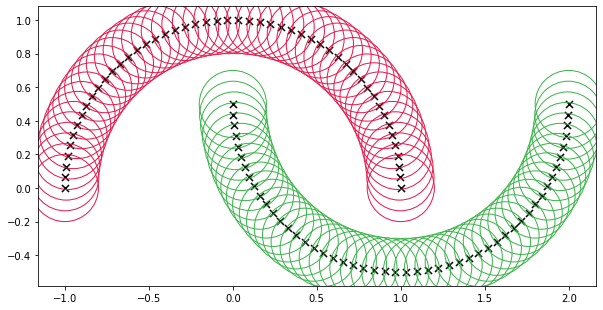

In [24]:

def compute_distances(input_X, dataset_X):
    """Takes in an array of inputs and finds each of their distances from every example in a dataset"""
    l = len(input_X)
    m = len(dataset_X)
    distances = np.zeros((l, m))
    for i in range(l):
        this_x = input_X[i]
        for j in range(m):
            another_x = dataset_X[j]
            distance = np.linalg.norm(this_x - another_x) # compute euclidian distance
            # print(distance)
            distances[i][j] = distance
    return distances

class DBSCAN:
    def __init__(self, X, epsilon=5, min_pts=3):
        self.X = X
        self.epsilon = epsilon # the radius of the neighbourhood of each core point
        self.min_pts = min_pts + 1 # because we dont want it to consider itself as a neighbour
        # self.dataset_predictions = self.predict(self.X, self.X)
    
    # def classify_neighbours(self, x)

    def predict(self, X):
        # print(X)
        m = len(X)
        distances = compute_distances(X, self.X)
        within_radius = np.zeros_like(distances)
        within_radius[distances <= self.epsilon] = 1
        
        print('distances:', distances.shape)
        # print(within_radius)
        n_within_radius = np.sum(within_radius, axis=1)
        # print(n_within_radius)
        # core_points = n_within_radius >= self.min_pts
        core_pt_idxs = np.where(n_within_radius >= self.min_pts)[0]
        # print('core pts:', core_pt_idxs)
        non_core_pt_idxs = np.where(np.logical_and(n_within_radius > 1, n_within_radius < self.min_pts))[0]
        # print('non core pts:', non_core_pt_idxs)
        noise_pt_idxs = np.where(n_within_radius == 1)[0] # 1 because they will always be within their own neighbourhood
        # print('noise pts:', noise_pt_idxs)
        predictions = np.ones(m)
        # print(predictions)
        cluster_idx = 0
        n_clusters_found = 0

        indices_of_core_pts_classified = set() ## make a set of all of the points which we've classified so far

        # def get_indices_in_cluster(idx)
        #     indices_in_cluster = set() ## initialise an empty set (save youself extra work by using a set rather than a list)

        #     neighbour_idxs = get_neighbour_idxs(distances[idx])
        #     indices_in_cluster.add(neighbour_idxs)
        #     while True:   

        #         for neighbour_idx in neighbour_idxs:
        #             # if neighbour_idx in indices_in_cluster: continue ## if neighbour already in cluster, don't include it again
        #             new_neighbour_idxs = get_neighbour_idxs(distances[neighbour_idx])

        #             print('adding neighbour:', neighbour_idx)
        #             indices_in_cluster.add(neighbour_idx)
        #     return indices_in_cluster

        def get_neighbours_and_add_to_cluster(idx, cluster=set()):
            # print('idx:', idx)
            neighbour_idxs = get_neighbour_idxs(distances[idx])
            for i in neighbour_idxs:
                # print('i:', i)
                if i in cluster: continue
                cluster.add(i)
                child_cluster = get_neighbours_and_add_to_cluster(i, cluster)
                cluster = cluster.union(child_cluster)
            return cluster

        def get_neighbour_idxs(neighbour_distances):
            n = np.where(neighbour_distances <= self.epsilon)[0] ## get indices of points within radius
            # print(n)
            return n

        for idx in core_pt_idxs: ## for each example idx
            print('cluster idx:', n_clusters_found)
            cluster = get_neighbours_and_add_to_cluster(idx)
            # print(cluster)
            cluster = list(cluster)
            print(len(cluster))
            predictions[cluster] = n_clusters_found
            n_clusters_found += 1
            break
            # sfsdv
            # # print(len(in_radius_idxs))
            # # sdfs
            # # print(in_radius_idxs)
            # # print('neighbour predictions:', predictions[in_radius_idxs])
            # # print(predictions)
            # if np.any(predictions[in_radius_idxs]):# if any neighbours are classified
            #     # print(predictions[in_radius_idxs])
            #     # print('classified neighbours')
            #     cluster_idx = np.max(predictions[in_radius_idxs]) # get the classification arbitrarily breaking ties
            #     predictions[idx] = cluster_idx # classify this point with the same type
            # else: # else
            #     # print('no classified neightbours')
            #     new_cluster_idx = n_clusters_found + 1 # increment the number of clusters found
            #     predictions[idx] = new_cluster_idx # classify this point as a member of a new cluster
            #     n_clusters_found += 1
        return predictions.astype(int)

    def predict_vis(self, X):
        self.predict()

    def visualise(self, predictions):
        plt.ion()
        plt.show()
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111)
        ax.set_aspect('equal')

        for cluster_idx in list(set(predictions)):
            # print(cluster_idx)
            cluster_datapoints = X[predictions == cluster_idx]
            ax.scatter(cluster_datapoints[:, 0], cluster_datapoints[:, 1], s=50, marker='x', c='k')
            for x in cluster_datapoints:
                circle = plt.Circle((x[0], x[1]), self.epsilon, color=colors[cluster_idx], fill=False)
                ax.add_artist(circle)
                # fig.canvas.draw()
                # sleep(0.1)
        # plt.scatter(X[:, 0], X[:, 1], s=500, marker='o', c='r')
        plt.show()

dbscan = DBSCAN(X, epsilon=0.2, min_pts=2)
cluster_predictions = dbscan.predict(X)
print(cluster_predictions)
dbscan.visualise(dbscan.predict(X))
# print('beginning visualisation')
# visualise_predictions(dbscan.predict, X, Y)

Limitations of DBSCAN
- We need to compute the distance between each point and each other point